In [1]:
import numpy as np
import string
try:
    maketrans = ''.maketrans
except AttributeError:
    # fallback for Python 2
    from string import maketrans

import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM, Embedding, CuDNNLSTM, Bidirectional,SpatialDropout1D
from keras.callbacks.callbacks import EarlyStopping
from keras import initializers,regularizers,constraints
from keras.layers import Layer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.backend import sigmoid
import keras.backend as K
import seaborn as sns
from sklearn.model_selection import cross_val_score 

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framewo

# Data Preprocessing

In [2]:
def data_preprocessing(document):
    document["Question"] = document["Question"].apply(lambda x: x.lower() \
    .translate(maketrans("","", string.punctuation)) \
    .strip()) 
    stop_words = set(stopwords.words("english"))
    stemmer= PorterStemmer()
    document["Question"] = document["Question"].apply(lambda x: remove_stopwords(x,stop_words,stemmer))
    display(document)
    return document

def remove_stopwords(sentense,stop_words,stemmer):
    tokens = word_tokenize(sentense)
    result = [stemmer.stem(i) for i in tokens if not i in stop_words]
    return ' '.join(result)

# Swish (Self-defined activation function)

In [3]:
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

# Attention Layer

In [4]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [5]:
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape = (input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape = (input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape = (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Model
The following code produce two BiDirectional RNN models. They both contain an embedding layer and LSTM (Long Short-Term Memory) layer. RNNwithAttention refer to the model with an extra layer of attention. While RNN does not.

In [6]:
MAX_FEATURE = 0
EMBED_SIZE = 300
MAX_LENGTH = 50

#Preparing the data
doc = pd.read_excel('data.xlsx',header=0)
doc = data_preprocessing(doc)

tokenizer = Tokenizer(num_words=MAX_FEATURE, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(doc["Question"].values)
MAX_FEATURE = len(tokenizer.word_index) + 1

X = tokenizer.texts_to_sequences(doc["Question"].values)
X = pad_sequences(X, maxlen=MAX_LENGTH)
Y = pd.get_dummies(doc["Label"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

#Preparing the models
epochs = 100
batch_size = 64

RNNwithAttention = Sequential()
RNNwithAttention.add(Embedding(MAX_FEATURE, EMBED_SIZE, input_length=X.shape[1]))
RNNwithAttention.add(SpatialDropout1D(0.2))
RNNwithAttention.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
RNNwithAttention.add(AttentionWithContext())
#RNNwithAttention.add(Dense(64, activation="swish"))
RNNwithAttention.add(Dense(4, activation='softmax'))
RNNwithAttention.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

RNNwithAttention.save_weights('RNN with Attention Initializer.h5')



RNN = Sequential()
RNN.add(Embedding(MAX_FEATURE, EMBED_SIZE, input_length=X.shape[1]))
RNN.add(SpatialDropout1D(0.2))
RNN.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
#RNN.add(AttentionWithContext())
#RNN.add(Dense(64, activation="swish"))
RNN.add(Dense(4, activation='softmax'))
RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

RNN.save_weights('RNN Initializer.h5')



,Question,Label
0,follow segment code part program use insert so...,"Counting Lists, Permutations, and Subsets"
1,five school go send basebal team tournament te...,"Counting Lists, Permutations, and Subsets"
2,mani way draw first card second card deck 52 card,"Counting Lists, Permutations, and Subsets"
3,mani way draw two card deck 52 card,"Counting Lists, Permutations, and Subsets"
4,mani way draw first second third card deck 52 ...,"Counting Lists, Permutations, and Subsets"
5,mani way tenperson club select presid secretar...,"Counting Lists, Permutations, and Subsets"
6,mani way tenperson club select twoperson execu...,"Counting Lists, Permutations, and Subsets"
7,mani way tenperson club select presid twoperso...,"Counting Lists, Permutations, and Subsets"
8,element set n nelement set mani order pair fir...,"Counting Lists, Permutations, and Subsets"
9,local ice cream shop sell ten differ flavor ic...,"Counting Lists, Permutations, and Subsets"


{'n': 1, '1': 2, 'x': 3, 'number': 4, 'mani': 5, 'b': 6, 'integ': 7, '—': 8, 'use': 9, '2': 10, 'set': 11, 'way': 12, 'tn': 13, 'k': 14, 'recurr': 15, 'statement': 16, '“': 17, 'solut': 18, 'prove': 19, 'mod': 20, '”': 21, 'one': 22, 'c': 23, '0': 24, 'e': 25, 'p': 26, 'differ': 27, 'explain': 28, 'find': 29, 'prime': 30, 'show': 31, 'v': 32, 'two': 33, '4': 34, 'big': 35, 'assum': 36, 'follow': 37, 'element': 38, '3': 39, 'equival': 40, 'comput': 41, 'function': 42, 'power': 43, 'give': 44, '5': 45, 'bound': 46, 'choos': 47, 'multipl': 48, '’': 49, 'problem': 50, 'theorem': 51, 'posit': 52, 'equat': 53, 'suppos': 54, 'three': 55, 'write': 56, 'list': 57, 'f': 58, 'messag': 59, 'know': 60, 'equal': 61, 'invers': 62, 'relat': 63, 'z': 64, 'recurs': 65, 'draw': 66, 'solv': 67, '•': 68, 'odd': 69, 'j': 70, 'make': 71, 'may': 72, 'get': 73, 'digit': 74, 'proof': 75, 'true': 76, 'induct': 77, 'tree': 78, 'must': 79, 'product': 80, 'form': 81, 'sn': 82, 'r': 83, 'say': 84, 'principl': 85, 'r

# Cross Validatoin
The following code performs cross validation with fold = 10 to the two models above

,Question,Label
0,let px stand “ x prime ” qx “ x even ” r x sta...,"Propositional logic, Predicate logic, Inferenc..."
1,find follow x 15f b x y5 c x 25 x — 15,"Counting Lists, Permutations, and Subsets"
2,suppos want comput aeievem mod n discuss wheth...,Details of the RSA Cryptosystem
3,suppos organ panel discuss allow alcohol campu...,"Counting Lists, Permutations, and Subsets"
4,prove demorgan law state —p q —p v —q,"Propositional logic, Predicate logic, Inferenc..."
5,use sx z statement x yz x statement x form def...,"Propositional logic, Predicate logic, Inferenc..."
6,function g call invers function f domain g ran...,"Counting Lists, Permutations, and Subsets"
7,extend proof preliminari version master theore...,The Master Theorem
8,consid follow slight modif theorem 32 part eit...,"Propositional logic, Predicate logic, Inferenc..."
9,follow segment code part program use insert so...,"Counting Lists, Permutations, and Subsets"



Train on 218 samples, validate on 25 samples
Epoch 1/100
218/218 [==============================] - 1s 4ms/step - loss: 1.3805 - accuracy: 0.3349 - val_loss: 1.3644 - val_accuracy: 0.4800
Epoch 2/100
218/218 [==============================] - 0s 747us/step - loss: 1.3330 - accuracy: 0.6284 - val_loss: 1.3371 - val_accuracy: 0.5600
Epoch 3/100
218/218 [==============================] - 0s 725us/step - loss: 1.2777 - accuracy: 0.6560 - val_loss: 1.2996 - val_accuracy: 0.5200
Epoch 4/100
218/218 [==============================] - 0s 717us/step - loss: 1.1975 - accuracy: 0.6560 - val_loss: 1.2531 - val_accuracy: 0.4800
Epoch 5/100
218/218 [==============================] - 0s 718us/step - loss: 1.0961 - accuracy: 0.6927 - val_loss: 1.1875 - val_accuracy: 0.5200
Epoch 6/100
218/218 [==============================] - 0s 722us/step - loss: 0.9688 - accuracy: 0.7339 - val_loss: 1.0982 - val_accuracy: 0.5600
Epoch 7/100
218/218 [==============================] - 0s 720us/step - loss: 0.8156 - 

Epoch 18/100
218/218 [==============================] - 0s 723us/step - loss: 0.2122 - accuracy: 0.9725 - val_loss: 0.7102 - val_accuracy: 0.7600
Epoch 19/100
218/218 [==============================] - 0s 724us/step - loss: 0.1729 - accuracy: 0.9771 - val_loss: 0.7764 - val_accuracy: 0.8000
Epoch 20/100
218/218 [==============================] - 0s 719us/step - loss: 0.1608 - accuracy: 0.9771 - val_loss: 0.7134 - val_accuracy: 0.8400
Train on 218 samples, validate on 25 samples
Epoch 1/100
218/218 [==============================] - 0s 731us/step - loss: 1.3853 - accuracy: 0.2385 - val_loss: 1.3738 - val_accuracy: 0.5600
Epoch 2/100
218/218 [==============================] - 0s 724us/step - loss: 1.3694 - accuracy: 0.5596 - val_loss: 1.3590 - val_accuracy: 0.7200
Epoch 3/100
218/218 [==============================] - 0s 720us/step - loss: 1.3480 - accuracy: 0.7064 - val_loss: 1.3409 - val_accuracy: 0.7600
Epoch 4/100
218/218 [==============================] - 0s 721us/step - loss: 1.320

Epoch 21/100
219/219 [==============================] - 0s 733us/step - loss: 0.0660 - accuracy: 1.0000 - val_loss: 0.4964 - val_accuracy: 0.8333
Epoch 22/100
219/219 [==============================] - 0s 734us/step - loss: 0.0456 - accuracy: 1.0000 - val_loss: 0.4860 - val_accuracy: 0.7917
Epoch 23/100
219/219 [==============================] - 0s 716us/step - loss: 0.0400 - accuracy: 1.0000 - val_loss: 0.4826 - val_accuracy: 0.7917
Epoch 24/100
219/219 [==============================] - 0s 723us/step - loss: 0.0309 - accuracy: 0.9954 - val_loss: 0.4851 - val_accuracy: 0.7917
Epoch 25/100
219/219 [==============================] - 0s 733us/step - loss: 0.0246 - accuracy: 1.0000 - val_loss: 0.4927 - val_accuracy: 0.7917
Epoch 26/100
219/219 [==============================] - 0s 720us/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.5088 - val_accuracy: 0.7917
Train on 219 samples, validate on 24 samples
Epoch 1/100
219/219 [==============================] - 0s 721us/step - loss: 1.

218/218 [==============================] - 0s 736us/step - loss: 1.3871 - accuracy: 0.2431 - val_loss: 1.3769 - val_accuracy: 0.2800
Epoch 2/100
218/218 [==============================] - 0s 759us/step - loss: 1.3786 - accuracy: 0.3440 - val_loss: 1.3641 - val_accuracy: 0.5200
Epoch 3/100
218/218 [==============================] - 0s 751us/step - loss: 1.3662 - accuracy: 0.3807 - val_loss: 1.3456 - val_accuracy: 0.3200
Epoch 4/100
218/218 [==============================] - 0s 747us/step - loss: 1.3594 - accuracy: 0.3807 - val_loss: 1.3298 - val_accuracy: 0.3200
Epoch 5/100
218/218 [==============================] - 0s 745us/step - loss: 1.3499 - accuracy: 0.4220 - val_loss: 1.3194 - val_accuracy: 0.3200
Epoch 6/100
218/218 [==============================] - 0s 751us/step - loss: 1.3389 - accuracy: 0.4495 - val_loss: 1.3115 - val_accuracy: 0.3200
Epoch 7/100
218/218 [==============================] - 0s 753us/step - loss: 1.3319 - accuracy: 0.4495 - val_loss: 1.3042 - val_accuracy: 0.36

Epoch 2/100
219/219 [==============================] - 0s 752us/step - loss: 1.3768 - accuracy: 0.3516 - val_loss: 1.3668 - val_accuracy: 0.3750
Epoch 3/100
219/219 [==============================] - 0s 744us/step - loss: 1.3613 - accuracy: 0.4155 - val_loss: 1.3546 - val_accuracy: 0.3750
Epoch 4/100
219/219 [==============================] - 0s 750us/step - loss: 1.3540 - accuracy: 0.3973 - val_loss: 1.3435 - val_accuracy: 0.3750
Epoch 5/100
219/219 [==============================] - 0s 742us/step - loss: 1.3440 - accuracy: 0.4064 - val_loss: 1.3335 - val_accuracy: 0.3750
Epoch 6/100
219/219 [==============================] - 0s 761us/step - loss: 1.3323 - accuracy: 0.4429 - val_loss: 1.3238 - val_accuracy: 0.3750
Epoch 7/100
219/219 [==============================] - 0s 741us/step - loss: 1.3205 - accuracy: 0.4521 - val_loss: 1.3119 - val_accuracy: 0.4583
Epoch 8/100
219/219 [==============================] - 0s 749us/step - loss: 1.3045 - accuracy: 0.5160 - val_loss: 1.2948 - val_ac

Epoch 14/100
219/219 [==============================] - 0s 737us/step - loss: 0.9253 - accuracy: 0.7763 - val_loss: 1.0372 - val_accuracy: 0.7083
Epoch 15/100
219/219 [==============================] - 0s 744us/step - loss: 0.8113 - accuracy: 0.8082 - val_loss: 0.9570 - val_accuracy: 0.7083
Epoch 16/100
219/219 [==============================] - 0s 744us/step - loss: 0.6971 - accuracy: 0.8447 - val_loss: 0.8851 - val_accuracy: 0.7500
Epoch 17/100
219/219 [==============================] - 0s 745us/step - loss: 0.5561 - accuracy: 0.9087 - val_loss: 0.8197 - val_accuracy: 0.6667
Epoch 18/100
219/219 [==============================] - 0s 744us/step - loss: 0.4313 - accuracy: 0.9361 - val_loss: 0.7416 - val_accuracy: 0.7083
Epoch 19/100
219/219 [==============================] - 0s 739us/step - loss: 0.3120 - accuracy: 0.9589 - val_loss: 0.6389 - val_accuracy: 0.8333
Epoch 20/100
219/219 [==============================] - 0s 751us/step - loss: 0.2252 - accuracy: 0.9635 - val_loss: 0.5654 -

,model_name,fold_idx,accuracy
0,RNN,0,0.760000
1,RNN,1,0.880000
2,RNN,2,0.840000
3,RNN,3,0.880000
4,RNN,4,0.666667
5,RNN,5,0.875000
6,RNN,6,0.750000
7,RNN,7,0.791667
8,RNN,8,0.916667
9,RNN,9,0.826087


model_name
RNN                   0.818609
RNN with Attention    0.777457
Name: accuracy, dtype: float64

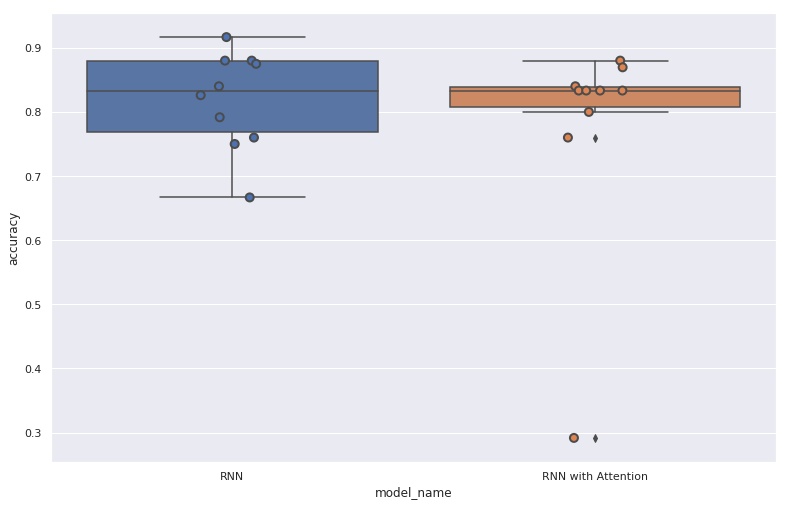

In [8]:
def KerasKFoldCrossVal(models,X,Y,fold=10):
    from sklearn.model_selection import StratifiedKFold
    seed = np.random.randint(low=1, high=100)
    #np.random.seed(seed)
    figureSize = (13,8.27)
    sns.set(rc={'figure.figsize':figureSize})
    entries = []
    cv_df = pd.DataFrame(index=range(fold * len(models))) 
    kfold = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)
    model_names = ['RNN','RNN with Attention']
    for i,model in enumerate(models):
        model_name = model_names[i]
        for fold_idx,dataSlice in enumerate(kfold.split(X, Y)): 
            
            train = dataSlice[0]
            test = dataSlice[1]

            tempX = tokenizer.texts_to_sequences(X[train])
            tempX = pad_sequences(tempX, maxlen=MAX_LENGTH)
            tempY = pd.get_dummies(Y[train])
            testX = tokenizer.texts_to_sequences(X[test])
            testX = pad_sequences(testX, maxlen=MAX_LENGTH)
            testY = pd.get_dummies(Y[test])

            model.load_weights('{} Initializer.h5'.format(model_name))
            
            epochs = 100
            batch_size = 64
            history = model.fit(tempX,tempY, epochs=epochs, batch_size=batch_size ,validation_data=(testX,testY), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
            # evaluate the model
            accuracy = history.history['val_accuracy']
            accuracy = accuracy[-1]
            entries.append([model_name,fold_idx, accuracy])
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy']) 
    display(cv_df)
    sns.boxplot(x='model_name', y='accuracy', data=cv_df) 
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
    KerasKFoldMean = cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)
    return KerasKFoldMean


models = [RNN,RNNwithAttention]
doc = pd.read_excel('data.xlsx',header=0)
doc = doc.sample(frac=1).reset_index(drop=True)
doc = data_preprocessing(doc)

pureX = doc["Question"].values
pureY = doc["Label"].values
KfoldMean = KerasKFoldCrossVal(models, pureX, pureY)
KfoldMean

# New input

In [9]:
new_question = ['Recursion tree diagram to find the solution to the recurrence. Assume n is a power of 2.']
seq = tokenizer.texts_to_sequences(new_question)
padded = pad_sequences(seq, maxlen=MAX_LENGTH)
pred = model.predict(padded)
labels = ["Counting Lists, Permutations, and Subsets",'Details of the RSA Cryptosystem', 'Propositional logic, Predicate logic, Inference and proofs', 'The Master Theorem']
print(pred, labels[np.argmax(pred)])

[[0.00472257 0.00362998 0.00855551 0.983092  ]] The Master Theorem
